<span style="font-size:36px"><b>Foundation of Statistics</b></span>

Copyright 2019 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [37]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from edapy.edapy import transformation
from edapy.edapy import plotting

In [3]:
# Tukey's fences outlier removal using k=3
def outlier_removal(X, method='Tukey', k=3):
    Q3 = X.quantile(0.75)
    Q1 = X.quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + 3*IQR
    lower = Q1 - 3*IQR
    res = (X < lower) | (X > upper)
    return res

In [4]:
def z_score(X):
    mean = X.mean()
    std = X.std()
    z = (X - mean) / std
    return z

# Import Data

The original dataset can be found here at [Google Drive](https://drive.google.com/drive/folders/1Rih-ODbqoIeWsWyTKbVaJTnNjUqBb_w2). THe followings are the columns in the data.
* Kontrak 		: nomor kontrak
* Tipe_Kendaraan 		: tipe kendaraan yang dibeli
* Pekerjaan 		: jenis pekerjaan
* Area 			: area kantor tempat kredit diberikan
* Tenor 			: jangka waktu hutang yang diajukan (bulan)
* Bucket_Collectability 	: keterlambatan membayar hutang (hari)
* NPF			: non performing financing
* Total_AR 		: jumlah pinjaman yang diterima (juta rupiah)
* LTV 			: loan to value (%)
* OTR 			: harga beli mobil setelah ditambahkan dengan seluruh pajak dan berbagai dokumen lainnya (puluh juta rupiah)
* Age 			: usia (tahun)
* Interest_Rate 		: suku bunga bank indonesia (%)
* Income 			: pendapatan (juta rupiah)
* DP 			: uang muka (juta rupiah)
* AF 			: amount financed (juta rupiah)
* Tujuan 			: tujuan pembelian
* Pendidikan 		: tingkat pendidikan
* Tanggungan 		: jumlah tanggungan keluarga
* Status 			: status pernikahan peminjam
* Gender 			: gender peminjam
* Paket 			: paket kredit
* Inflasi 		: tingkat inflasi (%)
* Segmen 			: segmentasi transaksi

Date accessed: October 25, 2019

In [5]:
data = pd.read_excel("xlsx/data_loan.xlsx", index_col='Kontrak')

In [6]:
data.shape

(28293, 22)

# Task

1. Ambil sample secara acak dari data loan sebanyak 80% dari banyakanya data.
2. Lakukan analisis statistik menggunakan metode-metode yang telah dipelajari di kelas ini. Analisis dilakukan sesuai kreativitas anda dengan mempertimba waktu yang tersedia.

<span style="font-size:30px">Analysis: **Predicting Amount of Total_AR application**.</span>
<br><span style="font-size:16px"><br>Model: **Linear Regression (Ordinary Least Square)**</span>
<br><span style="font-size:16px"><br>Metrics: **RMSE (Root Mean Square Error)**</span>

## Data Preprocessing

* Transform numerical datatype that is actually categorical.
* Separate numerical and categorical column
* Perform random sample of 80% of data

In [7]:
transformation.convert_to_categorical(data)

Column Tipe_Kendaraan casted to categorical
Column Pekerjaan casted to categorical
Column Area casted to categorical
Column Tenor casted to categorical
Column Bucket_Collectability casted to categorical
Column NPF casted to categorical
Column Tujuan casted to categorical
Column Pendidikan casted to categorical
Column Tanggungan casted to categorical
Column Status casted to categorical
Column Gender casted to categorical
Column Paket casted to categorical
Column Segmen casted to categorical


Create target columns

In [8]:
col_target = 'Total_AR'

In [9]:
cols_num = data.select_dtypes(include=[np.number]).columns
cols_cat = data.select_dtypes(exclude=[np.number]).columns

Sample 80% of data.

In [10]:
sample_size = int(0.8 * data.shape[0])
data_s = data.sample(sample_size, random_state=42)
print("Sample size of {}, with population size of {}. Ratio of {:2f}".format(sample_size, data.shape[0], sample_size/data.shape[0]))

Sample size of 22634, with population size of 28293. Ratio of 0.799986


## Data Understanding

* Check missing & null data, remove them
* Check duplicated data, remove them

In [11]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22634 entries, 22305 to 23275
Data columns (total 22 columns):
Tipe_Kendaraan           22634 non-null category
Pekerjaan                22634 non-null category
Area                     22634 non-null category
Tenor                    22634 non-null category
Bucket_Collectability    22634 non-null category
NPF                      22634 non-null category
Total_AR                 22634 non-null float64
LTV                      22634 non-null float64
OTR                      22634 non-null float64
Age                      22634 non-null int64
Interest_Rate            22634 non-null float64
Income                   22634 non-null int64
DP                       22634 non-null float64
AF                       22634 non-null float64
Tujuan                   22634 non-null category
Pendidikan               22634 non-null category
Tanggungan               22634 non-null category
Status                   22634 non-null category
Gender           

No missing values for current data, which is good. Now check for duplicated data.

In [12]:
data_s.index.duplicated().sum()

0

No duplicated data, we can proceed.

We see that our target variable has a looks like normal distribution, no need for extra transformation of our target variable.

### Numerical Columns

See how our variable correlates with our target variable.

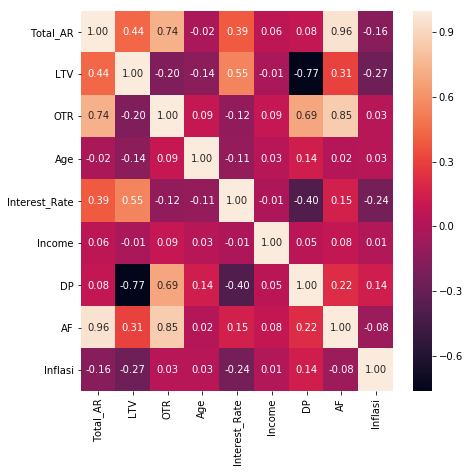

In [13]:
plt.figure(figsize=(7, 7))
sns.heatmap(data_s[cols_num].corr(), annot=True, fmt='.2f')
plt.show()

In [14]:
filt_cols = list(cols_num[1:]) # exlude our target column
filt_cols

['LTV', 'OTR', 'Age', 'Interest_Rate', 'Income', 'DP', 'AF', 'Inflasi']

From the correlation heatmap, we can conclude, for feature engineering, decide to remove attributes which has **more than 0.7** in correlation score
* LTV vs DP, **we remove DP** since LTV has higher correlation for our target variable `Total_AR`
* OTR vs AF, **we remove OTR** since AF has higher correlation for our target variable `Total_AR`

In [15]:
cols_remove = ['DP', 'OTR']
filt_cols = [x for x in filt_cols if x not in cols_remove]

Reassign filt_cols to cols_num

In [16]:
cols_num = filt_cols

Next we want to see the distribution of attributes, for not overfitting linear regression, it is considerably best to work with attributes that has normal distribution.
* Perform log transformation for skewed variable distribution

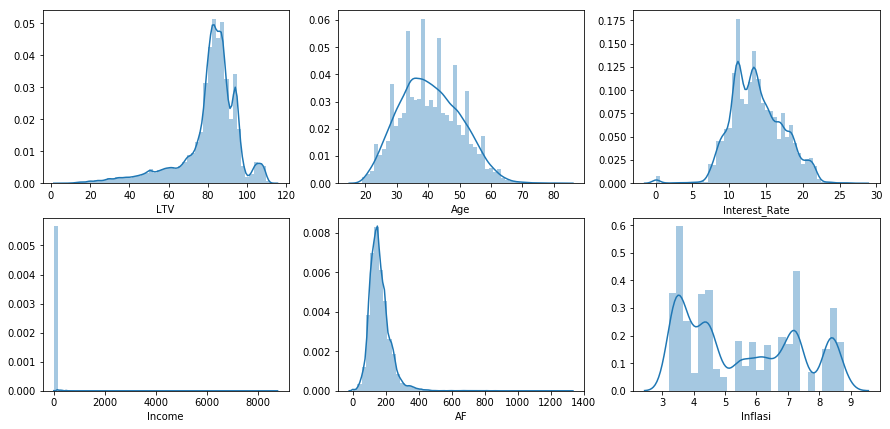

In [17]:
plotting.distplot_numerical(data_s, filt_cols)

* We need to do log transformation on column: `Income`
* We need to remove outlier for column `AF`
* We **may** need to remove outlier for column `LTV`, but for now, decide not to remove it.

In [18]:
# Log transformation
data_s['Income'] = np.log10(data_s['Income'])

# Outlier removal
AF_outlier = outlier_removal(data_s['AF']) # 135 total outlier

In [19]:
# Removes outliers
data_s = data_s[~AF_outlier]

Redraw the transformed and removed outliers data.

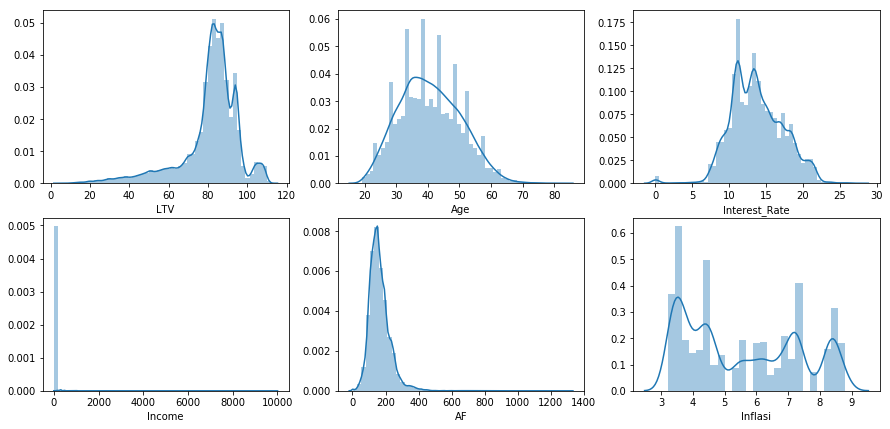

In [20]:
plotting.distplot_numerical(data, filt_cols)

### Target Column Distribution

See our target column distribution after outlier removal.

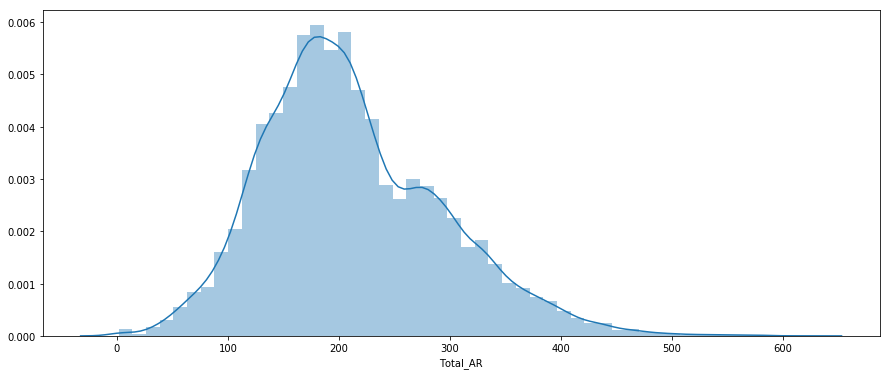

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(data_s[col_target], ax=ax)
plt.show()

### Categorical Columns

See distribution of `col_target` along each of our unique values in `cols_num`.

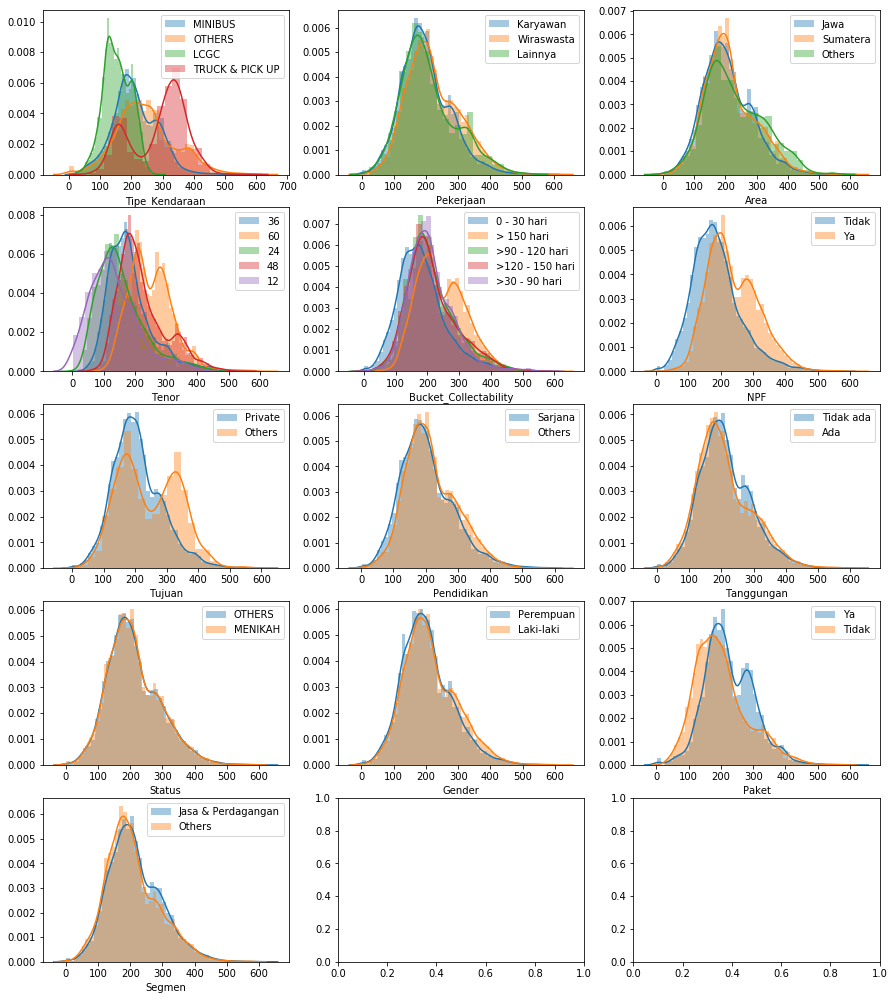

In [22]:
plotting.distplot_categorical(data_s, cols_cat, col_target)

* Potential strong predictor: `Tipe_Kendaraan`, `Area`, `Tenor`, `Bucket_Collectability`, `NPF`, `Tujuan`, `Paket`
* Potential good predictor: `Pekerjaan`, `Tanggungan`
* Not potential predictor: `Pendidikan`, `Status`, `Gender`, `Segmen` **we remove these variables**

In [23]:
cols_remove_cat = ['Pendidikan', 'Status', 'Gender', 'Segmen']
cols_cat = [x for x in cols_cat if x not in cols_remove_cat]

Replot to make sure of the results.

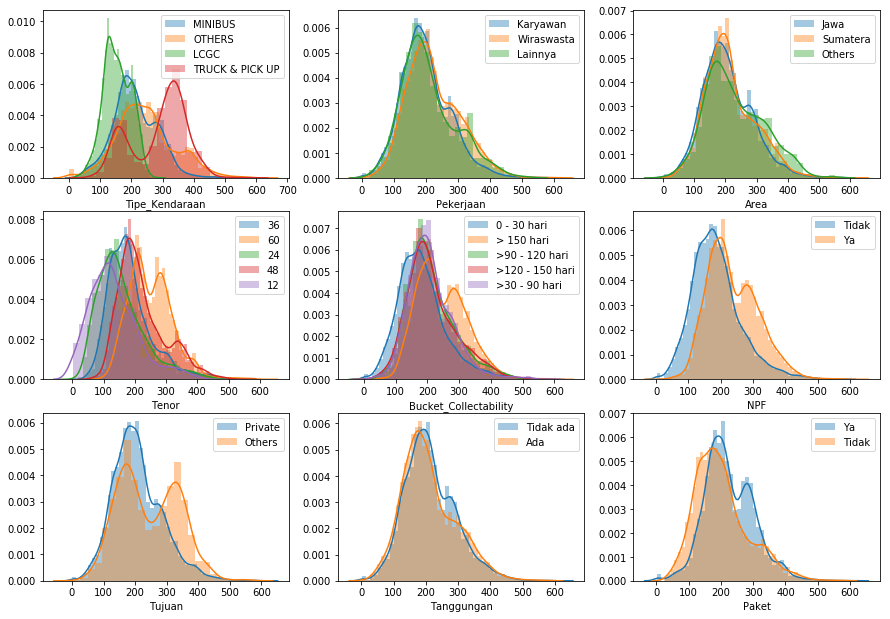

In [24]:
plotting.distplot_categorical(data_s, cols_cat, col_target)

## Data Processing

* Transform numerical variable and target variable to z-score
* Transform categorical variable into dummy variable, don't forget to remove one of the result from dummy variable

In [25]:
for col in cols_num+[col_target]:
    data_s['z_'+col] = z_score(data_s[col])

In [26]:
cols_num_z = ['z_'+x for x in cols_num]

In [27]:
for col in cols_cat:
    data_s = pd.concat([data_s, pd.get_dummies(data_s[col], prefix='d_'+col, drop_first=True)], axis=1)

In [28]:
cols_cat_d = [c for c in data_s.columns if 'd_' in c]

## Modelling

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [39]:
cols_feature = cols_num_z+cols_cat_d

In [40]:
X = data_s[[c for c in cols_feature]]
y = data_s['z_Total_AR']

In [41]:
reg = LinearRegression().fit(X, y)

In [42]:
coef = reg.coef_
intercept = reg.intercept_
print("y = {} + {} x".format(intercept, coef))

y = -0.3310357527694838 + [-3.13963727e-02  5.81123451e-04  1.68029363e-01 -3.06122469e-03
  8.90415285e-01  7.11696933e-04  4.78248643e-02  2.74772317e-02
  4.87358821e-02 -2.83498092e-03 -5.93070551e-04  4.53854416e-03
 -5.13632148e-03  8.17352031e-03  1.28202948e-01  2.36810399e-01
  4.58439161e-01  2.38751782e-02 -4.28830942e-03  5.45557354e-03
 -4.35175811e-03  1.52351107e-02 -3.27272211e-03  7.50455841e-03
  7.58795518e-02] x


In [43]:
preds = reg.predict(X)

In [44]:
rmse = math.sqrt(metrics.mean_squared_error(y.values, preds))
print("Root mean squared error: {:.3f}".format(rmse))

Root mean squared error: 0.114


In [45]:
r_square = metrics.r2_score(y.values, preds)
print("R-square: {:.3f}".format(r_square))

R-square: 0.987


Final predictors:

In [46]:
print(cols_num_z)
print(cols_cat)

['z_LTV', 'z_Age', 'z_Interest_Rate', 'z_Income', 'z_AF', 'z_Inflasi']
['Tipe_Kendaraan', 'Pekerjaan', 'Area', 'Tenor', 'Bucket_Collectability', 'NPF', 'Tujuan', 'Tanggungan', 'Paket']


For a data which scales from 0 to 1, **rmse of 0.114** and **R-square of 0.987** is quite good. But we need to perform validation on the other dataset, this will not be done in this notebook.

<hr>

# Class Exercise

Below is combination of what we do during the class and some improvements in visualization.

## Data Understanding

Separate numerical columns and categorical columns for analysis

In [59]:
cols_num = data.select_dtypes(include=[np.number]).columns
cols_cat = data.select_dtypes(exclude=[np.number]).columns

### Detecting Outliers

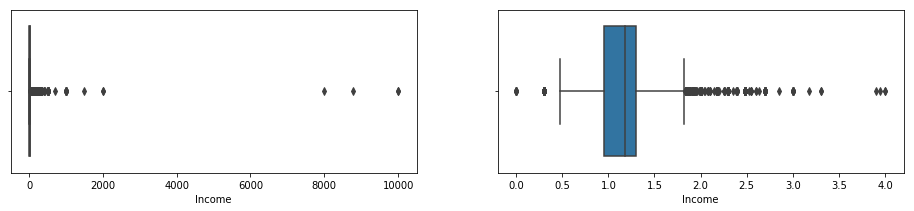

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
sns.boxplot((data['Income']), ax=ax[0])
sns.boxplot(np.log10(data['Income']), ax=ax[1])
plt.show()

Below use the rule of outlier > 3 z-score.

In [207]:
z_score = standardized_income
data[['Kontrak', 'Income']][np.abs(z_score) > 3].head()

,Kontrak,Income
4559,4560,1500
4611,4612,1000
4898,4899,500
4899,4900,500
4943,4944,500


Below example of using 1.5\*IQR rule to detect outlier.

In [208]:
Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (data['Income'] < (Q1 - 1.5*IQR)) | (data['Income'] > (Q3 + 1.5*IQR))

In [210]:
data[['Kontrak', 'Income']][outlier_mask].head()

,Kontrak,Income
86,87,50
126,127,100
127,128,60
187,188,50
204,205,40


### Hypothesis testing

In [213]:
from scipy.stats import ttest_ind

In [341]:
print(x1.std(), x2.std())

160.3068159692058 37.69079390497655


In [342]:
x1 = data['Income'][data['NPF'] == 'Ya']
x2 = data['Income'][data['NPF'] != 'Ya']

ttest_ind(x1, x2, equal_var=False)

Ttest_indResult(statistic=1.1440147059898442, pvalue=0.25263531221651053)

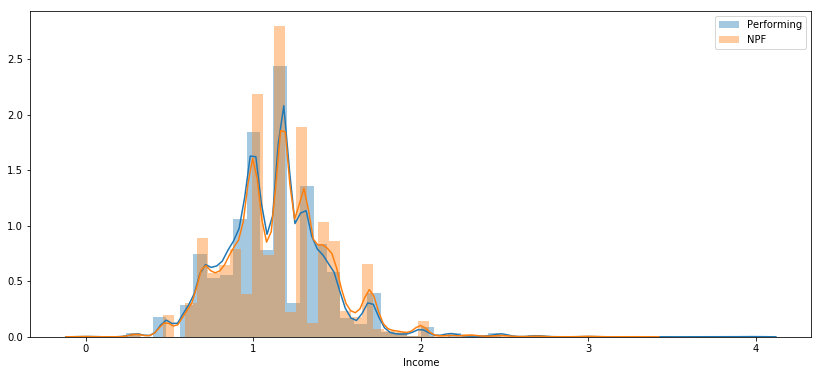

In [243]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.distplot(np.log10(x1))
sns.distplot(np.log10(x2))
plt.legend(["Performing", "NPF"])
plt.show()

## Data Transformation Excercises

### Edit `Tipe_Kendaraan`, flagging `Tipe_Kendaraan` as MINIBUS and NONMINIBUS.

In [60]:
data['Tipe_Kendaraan'] = ['MINIBUS' if x == 'MINIBUS' else 'NON_MINIBUS' for x in data['Tipe_Kendaraan']]

### Create dummy variable from `Area` columns, dropping first columns.

In [62]:
pd.concat([data, pd.get_dummies(data['Area'], prefix='Area', drop_first=True)], axis=1).head()

,Kontrak,Tipe_Kendaraan,Pekerjaan,Area,Tenor,Bucket_Collectability,NPF,Total_AR,LTV,OTR,...,Tujuan,Pendidikan,Tanggungan,Status,Gender,Paket,Inflasi,Segmen,Area_Others,Area_Sumatera
0,1,NON_MINIBUS,Karyawan,Jawa,12,>90 - 120 hari,Ya,2.763126,100.00,2.76,...,Private,Sarjana,Tidak ada,OTHERS,Laki-laki,Ya,3.58,Jasa & Perdagangan,0,0
1,2,NON_MINIBUS,Wiraswasta,Jawa,12,0 - 30 hari,Tidak,2.805000,103.70,2.71,...,Private,Others,Tidak ada,MENIKAH,Laki-laki,Ya,3.58,Others,0,0
2,3,NON_MINIBUS,Wiraswasta,Jawa,12,0 - 30 hari,Tidak,3.104000,103.33,3.00,...,Private,Sarjana,Tidak ada,OTHERS,Perempuan,Ya,4.17,Others,0,0
3,4,NON_MINIBUS,Karyawan,Jawa,12,0 - 30 hari,Tidak,4.088100,102.51,3.98,...,Private,Sarjana,Ada,OTHERS,Laki-laki,Ya,3.61,Jasa & Perdagangan,0,0
4,5,NON_MINIBUS,Karyawan,Jawa,12,0 - 30 hari,Tidak,4.607100,102.22,4.50,...,Private,Sarjana,Tidak ada,OTHERS,Perempuan,Ya,3.30,Jasa & Perdagangan,0,0


### Bin `LTV` variable into 5 bins with equal range bin.

In [75]:
pd.cut(data['LTV'], 5).head()

0    (90.486, 111.83]
1    (90.486, 111.83]
2    (90.486, 111.83]
3    (90.486, 111.83]
4    (90.486, 111.83]
Name: LTV, dtype: category
Categories (5, interval[float64]): [(5.003, 26.454] < (26.454, 47.798] < (47.798, 69.142] < (69.142, 90.486] < (90.486, 111.83]]

### Transformation `Income` to standard distribution, then normalized it to log scale.

In [174]:
mean = data['Income'].mean()
std = data['Income'].std() # Normalized by N-1 by default
standardized_income = np.array([(x-mean)/std for x in data['Income']])

In [175]:
data['Income'].describe()

count    28293.000000
mean        20.449334
std        115.608090
min          1.000000
25%          9.000000
50%         15.000000
75%         20.000000
max      10000.000000
Name: Income, dtype: float64

In [176]:
pd.Series(standardized_income).describe()

count    2.829300e+04
mean    -1.084246e-16
std      1.000000e+00
min     -1.682351e-01
25%     -9.903575e-02
50%     -4.713627e-02
75%     -3.886698e-03
max      8.632225e+01
dtype: float64

In [177]:
def log10_negative(x, e=0.001):    
    return np.log10(x - min(x) + e) + min(x)

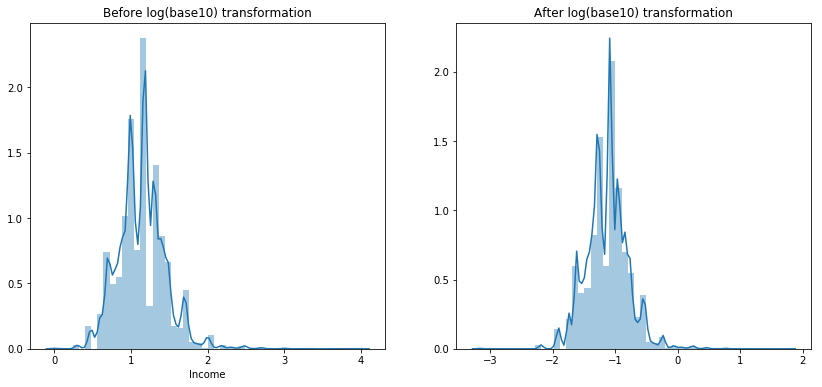

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.distplot(np.log10(data['Income']), ax=ax[0])
ax[0].set_title('Before log(base10) transformation')
sns.distplot(log10_negative(standardized_income), ax=ax[1])
ax[1].set_title('After log(base10) transformation')
plt.show()

## Modelling

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [333]:
x = (data['Income'])
y = data['Total_AR']
reg = LinearRegression().fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))

In [334]:
coef = reg.coef_
intercept = reg.intercept_
preds = (intercept[0] + x*coef[0][0])
print("y = {} + {} x".format(intercept[0], coef[0][0]))

y = 213.95548224047386 + 0.040179447387405386 x


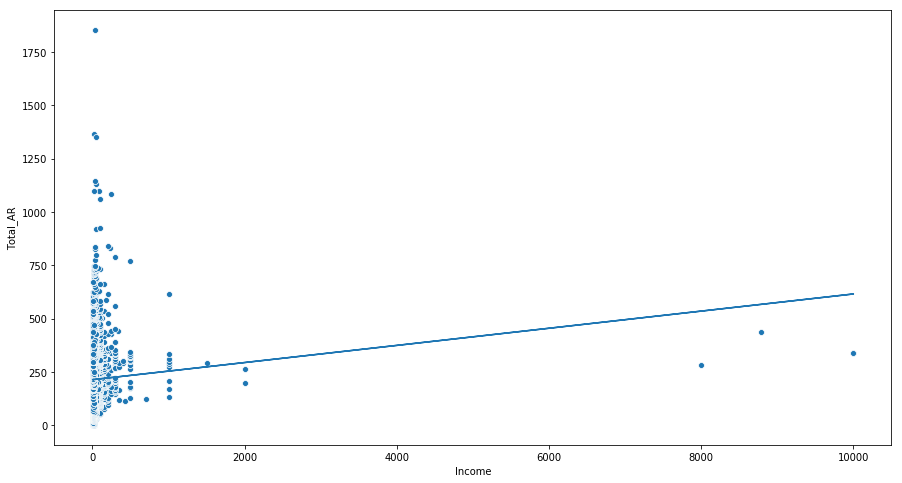

In [335]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=x, y=y, ax=ax)
plt.plot(x, preds)
plt.show()

In [323]:
import statsmodels.formula.api as smf

mc = pd.read_excel('xlsx/data_microchip.xlsx')
mc_stats = smf.ols('number_of_component ~ year_since_1959', data=mc).fit()

In [324]:
print(mc_stats.summary())

                             OLS Regression Results                            
Dep. Variable:     number_of_component   R-squared:                       0.719
Model:                             OLS   Adj. R-squared:                  0.626
Method:                  Least Squares   F-statistic:                     7.688
Date:                 Fri, 25 Oct 2019   Prob (F-statistic):             0.0694
Time:                         16:19:48   Log-Likelihood:                -19.423
No. Observations:                    5   AIC:                             42.85
Df Residuals:                        3   BIC:                             42.06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -8.9434     1

D:\Anaconda2019\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
